In [1]:
import pandas as pd
from EmotionAnalysis.DataSchemaExtractionParsing import *
from EmotionAnalysis.DataPreProcessing import *
from EmotionAnalysis.SentSemanticModule import *
from EmotionAnalysis.SentTweetModule import *
from EmotionAnalysis.SentSyntacticModule import *
from EmotionAnalysis.WordVectorRepresentationImplementations import *
import ast
%matplotlib inline
from collections import Counter
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

# I. Affective Representation of Annotated Dataset:

### 1. Loading Annotated Dataset:

In [2]:
plutchik_tweets = pd.read_csv('../../Data/Crowdsourced Data/primary-plutchik-wheel-DFE.csv',encoding="utf-8")
plutchik_tweets = plutchik_tweets[['text','emotion']]
plutchik_tweets.head()

,text,emotion
0,How much of the forecast was genuine and how m...,Neutral
1,I did touch them one time you see but of cours...,Neutral
2,We find that choice theorists admit that they ...,Neutral
3,"Well, here I am with an olive branch.",Neutral
4,"Its rudder and fin were both knocked out, and ...",Neutral


In [3]:
set(plutchik_tweets['emotion'])

{u'Aggression',
 u'Ambiguous',
 u'Anger',
 u'Anticipation',
 u'Awe',
 u'Contempt',
 u'Disapproval',
 u'Disgust',
 u'Fear',
 u'Joy',
 u'Love',
 u'Neutral',
 u'Optimism',
 u'Remorse',
 u'Sadness',
 u'Submission',
 u'Surprise',
 u'Trust'}

In [4]:
selective_8 = ['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust','Neutral']
plutchik_tweets_8emotions = plutchik_tweets[plutchik_tweets['emotion'].isin(selective_8)]

### 2. Visualizing the distribution of emotions in the annotated dataset:

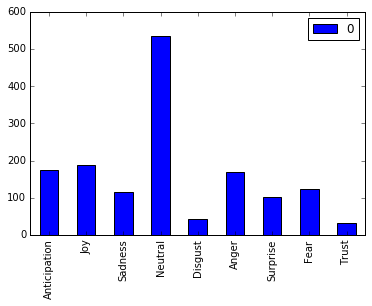

In [5]:
frequency = Counter(plutchik_tweets_8emotions['emotion'])
df = pd.DataFrame.from_dict(frequency, orient='index')
df.plot(kind='bar')

### 3. Applying the same nlp processing pipeline to get affective representation:

#### 3.1. Replacing English contractions:

In [6]:
tweets_no_contractions = replace_contractions(plutchik_tweets_8emotions)

#### 3.2. Tokenization of Sentences into words

In [7]:
tokenized_list = bag_of_word_representation(tweets_no_contractions)

#### 3.3. Part of Speech Tagging:

In [8]:
tagged_tweets = pos_tagging(tokenized_list)

#### 3.4. Dependency Parser:

In [9]:
nlp = spacy.load('en')

In [10]:
docs = []
# Joining text:
tweets_text = []
for i in range(0, len(tokenized_list)):
    space = " "
    tweets_text.append(space.join(tokenized_list[i]))
tweets_text[0].encode("utf-8")
for i in range(0, len(tweets_text)):
    doc = nlp(tweets_text[i])
    docs.append(doc)

In [11]:
new_samples = []
for sample in docs:
    new_samples_sub = []
    for word in sample:
        new_samples_sub.append((unicode(word),word.pos_))
    new_samples.append(new_samples_sub)

#### 3.5. Application of Syntactic Rules:

In [12]:
new_samples,triple_dependencies = apply_syntactic_rules(docs,new_samples)

In [13]:
i = 2
print "\n<<<< Original tweet text >>>\n"
print tweets_text[i]
print "\n<<<< Syntactic dependencies >>>\n"
print triple_dependencies[i]
print "\n<<<< Tweet after applying syntactic Rules >>>\n"
#print new_samples[i]
new_tweet = []
for (word,pos) in new_samples[i]:
    new_tweet.append(word)
print new_tweet


<<<< Original tweet text >>>

We find that choice theorists admit that they introduce style of moral paternalism at odds with liberal values

<<<< Syntactic dependencies >>>

[(u'we', u'nsubj', u'find'), (u'find', u'ROOT', u'find'), (u'that', u'mark', u'admit'), (u'choice', u'compound', u'theorist'), (u'theorist', u'nsubj', u'admit'), (u'admit', u'ccomp', u'find'), (u'that', u'mark', u'introduce'), (u'they', u'nsubj', u'introduce'), (u'introduce', u'ccomp', u'admit'), (u'style', u'dobj', u'introduce'), (u'of', u'prep', u'style'), (u'moral', u'amod', u'paternalism'), (u'paternalism', u'pobj', u'of'), (u'at', u'prep', u'introduce'), (u'odds', u'pobj', u'at'), (u'with', u'prep', u'odds'), (u'liberal', u'amod', u'value'), (u'value', u'pobj', u'with')]

<<<< Tweet after applying syntactic Rules >>>

[u'We', u'find', u'that', u'choice', u'theorists', u'admit', u'that', u'they', u'introduce', u'style', u'of', u'moral', u'at', u'odds', u'with', u'liberal', u'values']


#### 3.6 Named Entity Recognition:

In [14]:
tweet_without_ne = remove_named_entities(tagged_tweets)

#### 3.7. Normalizing POS Tags:

In [15]:
normalized_tags = normalize_pos_tags_words(tweet_without_ne)
normalized_tags[1]

[(u'did', 'v'),
 (u'touch', 'v'),
 (u'them', 'PRP'),
 (u'one', 'CD'),
 (u'time', 'n'),
 (u'you', 'PRP'),
 (u'see', 'v'),
 (u'but', 'CC'),
 (u'of', 'IN'),
 (u'course', 'n'),
 (u'there', 'EX'),
 (u'was', 'v'),
 (u'nothing', 'n'),
 (u'doing', 'v'),
 (u'he', 'PRP'),
 (u'wanted', 'v'),
 (u'me', 'PRP')]

#### 3.8. Removal of Punctuation and Stop words and Converting to Lower Case and Removal of Other special categories: url, number, username:

In [16]:
tagged_tweets_without = eliminate_stop_words_punct(normalized_tags)

#### 3.9. Lemmatization:

In [17]:
lemmatized_tweets = lemmatizer(tagged_tweets_without)

lemmatized_tweets_untag = lemmatizer_untagged(tagged_tweets_without)
lemmatized_tweets[0]

[(u'how', 'WRB'),
 (u'much', 'Adj'),
 (u'forecast', 'n'),
 (u'genuine', 'Adj'),
 (u'much', 'Adj'),
 (u'fix', 'v'),
 (u'moot', 'Adj'),
 (u'point', 'n')]

#### 3.10. Keeping only NAVA words:

In [18]:
nava_tweets = keep_only_nava_words(lemmatized_tweets)
nava_tweets[0]

[u'forecast', u'fix', u'point']

In [19]:
print (lemmatized_tweets[0])
print (nava_tweets[0])

[(u'how', 'WRB'), (u'much', 'Adj'), (u'forecast', 'n'), (u'genuine', 'Adj'), (u'much', 'Adj'), (u'fix', 'v'), (u'moot', 'Adj'), (u'point', 'n')]
[u'forecast', u'fix', u'point']


### 4. Storing affective word level representation:

In [20]:
annotated_nava_tweets_df = pd.DataFrame()
annotated_nava_tweets_df['Nava Representation'] = nava_tweets
annotated_nava_tweets_df['Tokenized Lemmatized'] = lemmatizer_raw(tagged_tweets)

annotated_nava_tweets_df.to_csv('../../Results/Annotated_Representation.csv')

### USE THIS TO LOAD DIRECTLY ALREADY FINISHED RAW TOKENIZED LEMMATIZED REPRESENTATION

In [21]:
annotated_tweets_df = pd.read_csv('../../Results/Annotated_Representation.csv')
tokenized_lemma_representation = annotated_tweets_df['Tokenized Lemmatized']
tokenized_lemmatized_tweets = []
for i in range(0, len(tokenized_lemma_representation)):
    result = ast.literal_eval(tokenized_lemma_representation[i])
    tokenized_lemmatized_tweets.append(result)

### USE THIS TO LOAD DIRECTLY ALREADY FINISHED AFFECTIVE REPRESENTATION

In [22]:
affective_representation = annotated_tweets_df['Nava Representation']
nava_tweets = []
for i in range(0, len(affective_representation)):
    result = ast.literal_eval(affective_representation[i])
    nava_tweets.append(result)

# II. Loading Unannotated Tweets

### 1. Loading Raw Lemmatized Representation:

In [23]:
unannotated_tweets_df = pd.read_csv('../../Results/Sample Affective Representation.csv')
tokenized_lemma_representation = unannotated_tweets_df['Tokenized Lemmatized']
unnatoted_tokenized_lemmatized_tweets = []
for i in range(0, len(tokenized_lemma_representation)):
    result = ast.literal_eval(tokenized_lemma_representation[i])
    unnatoted_tokenized_lemmatized_tweets.append(result)

### 2. Loading Nava Affective Representation:

In [24]:
affective_representation = unannotated_tweets_df['Nava Representation']
unannotated_nava_tweets = []
for i in range(0, len(affective_representation)):
    result = ast.literal_eval(affective_representation[i])
    unannotated_nava_tweets.append(result)

In [25]:
unannotated_nava_tweets[0]

[u'still', u'best', u'town']

# III. Word to Numerical Vector Representation:

### 1. Combining the small annotated dataset and whole unannotated tweets

In [26]:
tokenized_lemma_whole = tokenized_lemmatized_tweets + unnatoted_tokenized_lemmatized_tweets 

### 2. Training word2Vec on the combined list

In [59]:
# PARAMETERS TO BE TUNED:

# Word vector dimensionality                      
# Minimum word count                        
# Number of threads to run in parallel
# Context window size                                                                                    
# Downsample setting for frequent words

#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    #level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality
min_word_count = 1  # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(tokenized_lemma_whole, workers=num_workers,
            size=num_features, min_count = min_word_count,
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "../../Models/semi-supervised-model-en"
model.save(model_name)

Training model...


In [28]:
print (model.similarity('laugh','smile'))

0.994274900857


## USE THIS TO LOAD DIRECTLY PRE-TRAINED WORD2VEC MODEL:

In [35]:
model = Word2Vec.load('../../Models/semi-supervised-model-en')

### 3. Word2Vec Representation:

In [30]:
AnnotatedTweets = getAvgFeatureVecs(nava_tweets, model, 300)

In [32]:
UnAnnotatedTweets = getAvgFeatureVecs(unannotated_nava_tweets, model, 300)

## IV. Training ER models using Machine Learning Algorithms in an Semi-Supervised Manner

* Rational: 
A method for adapting consists in iteratively "auto-labeling" the target examples.
    * a model h is learned from the labeled source examples
    * h automatically labels SOME target examples;
    * a new model is learned from the new labeled examples.

* Trying the following Algorithms with domain adaptation:
    * Random Forest
    * GBM
    * Support Vector Machine with different kernels: linear, radial, polynomial.
    * Naive Bayes: bernoulli,gaussian, multinomial
    * Maximum Entropy 
    * K-nearest Neighbors
    * Decision Trees
* Fine Tuning model parameters
* Model Evaluation through Cross Validation
* Confusion Matrices
* Learning Curves

In [37]:
emo_dict = {
    'Anger':0,
    'Anticipation':1,
    'Disgust':2,
    'Fear':3,
    'Joy':4,
    'Sadness':5,
    'Surprise':6,
    'Trust':7,
    'Neutral':8
}
plutchik_tweets_8emotions['emotionId'] = [emo_dict[emotion] for emotion in plutchik_tweets_8emotions['emotion']]

### 1. Splitting X and y into training and testing:

In [38]:
X_train, X_test, y_train, y_test = train_test_split(AnnotatedTweets,plutchik_tweets_8emotions['emotionId'], test_size=0.3)

In [39]:
# Dealing with Unbalanced Classes:
def weight_sample(labels):
    """ We calculate the percentages for each class and add it to the sample_weights list"""
    
    weight_class = labels.value_counts()/len(labels)
    
    sample_weights = []
    for i in labels:
        sample_weights += [weight_class[i]]
        
    return np.array(sample_weights)

sample_weights = weight_sample(y_train)

### 2. Trying Random Forest:
#### 2.1. Training Random Forest with Domain Adaptation:

In [40]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
forest = RandomForestClassifier( n_estimators = 15, max_features = None )

# Training and predicting for only annotated dataset:
print ("Fitting a random forest to labeled training data....")
forest = forest.fit(X_train, y_train,sample_weight= sample_weights) 
result_train = forest.predict(X_train)
result_test = forest.predict(X_test)

iteration = 1
# Training and predicting using domain adaptation in an iterative fashion:
for i in range(0,3000,1000):
    print ("Fitting a random forest to training data using domain adaptation, ITERATION: "+str(iteration))
    
    # Predicting on a small subset of the unannotated dataset:
    subset_results = forest.predict(UnAnnotatedTweets[0+i:1000+i])
    X_train = np.concatenate((X_train,UnAnnotatedTweets[0+i:1000+i]))
    y_train = np.concatenate((y_train,subset_results))
    
    # Retraining model on the new annotated dataset:
    
    forest = forest.fit(X_train, y_train) 
    result_train = forest.predict(X_train)
    
    iteration = iteration + 1

result_test = forest.predict(X_test) # New Predictions for test dataset    

Fitting a random forest to labeled training data....
Fitting a random forest to training data using domain adaptation, ITERATION: 1
Fitting a random forest to training data using domain adaptation, ITERATION: 2
Fitting a random forest to training data using domain adaptation, ITERATION: 3


#### 2.2. Plotting Confusion Matrix for Training:

In [41]:
import matplotlib.pyplot as plt
from sklearn import metrics
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [42]:
cm=metrics.confusion_matrix(y_train, result_train)
print(cm)

[[1249    1    0    0    0    0    0    0    1]
 [   0  428    0    0    2    0    0    0    2]
 [   1    0   30    0    0    0    0    0    1]
 [   1    2    0  120    0    0    0    0    2]
 [   1    0    0    0  314    0    1    0    2]
 [   1    0    1    0    1  134    0    0    4]
 [   3    0    0    0    0    0   74    0    1]
 [   0    0    0    0    0    0    0   22    0]
 [   0    0    0    0    1    0    0    2 1636]]


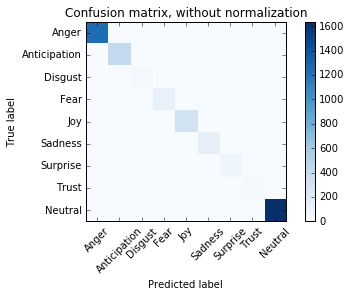

In [43]:
plot_confusion_matrix(cm, classes= ['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust','Neutral'],
                      title='Confusion matrix, without normalization')

We observe from the confusion matrix that the model does a good job recognizing Anger, Anticipation, Joy, Neutral while it doesn't recognize as well other emotions where the proportion of true positives is not that high.

#### 2.3. Plotting Confusion Matrix for Testing:

In [62]:
cm_test=metrics.confusion_matrix(y_test, result_test)
print(cm_test)

[[  4   3   0   1   2   0   0   0  25]
 [  6   3   0   0   5   1   0   0  26]
 [  5   1   1   0   0   0   0   0   3]
 [  4   3   0   1   3   1   1   0  30]
 [ 12   3   0   1  12   2   0   0  26]
 [  6   3   1   0   1   0   0   0  25]
 [  4   8   0   2   2   0   2   0  16]
 [  2   1   0   0   1   0   0   1   8]
 [ 17  12   2   2  16   1   0   1 126]]


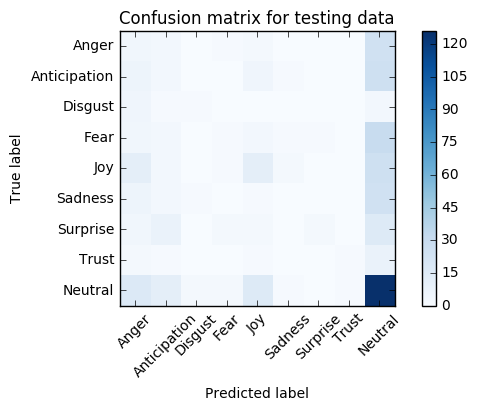

In [65]:
plot_confusion_matrix(cm_test, classes= ['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust','Neutral'],
                      title='Confusion matrix for testing data')

The model ability to predict Neutral is at its best, and its ability in training dataset to recognize anticipation, anger and joy transfers to some extent in the testing dataset.

#### 2.4. Model Evaluation For Training:

In [44]:
print('Accuracy Score: ',metrics.accuracy_score(y_train, result_train))

print('micro Precision Score: ',metrics.precision_score(y_train, result_train, average='micro'))
print('micro Recall Score: ',metrics.recall_score(y_train, result_train, average='micro'))
print('micro f1_score: ',metrics.f1_score(y_train, result_train, average='micro'))

print('macro Precision Score: ',metrics.precision_score(y_train, result_train, average='macro'))
print('macro Recall Score: ',metrics.recall_score(y_train, result_train, average='macro'))
print('macro f1_score: ',metrics.f1_score(y_train, result_train, average='macro'))


('Accuracy Score: ', 0.99232293214462608)
('micro Precision Score: ', 0.99232293214462608)
('micro Recall Score: ', 0.99232293214462608)
('micro f1_score: ', 0.99232293214462608)
('macro Precision Score: ', 0.98200880904615095)
('macro Recall Score: ', 0.97458950862574056)
('macro f1_score: ', 0.97791269553582638)


#### 2.4. Model Evaluation For Testing:

In [45]:
print('Accuracy Score: ',metrics.accuracy_score(y_test, result_test))

print('micro Precision Score: ',metrics.precision_score(y_test, result_test, average='micro'))
print('micro Recall Score: ',metrics.recall_score(y_test, result_test, average='micro'))
print('micro f1_score: ',metrics.f1_score(y_test, result_test, average='micro'))

print('macro Precision Score: ',metrics.precision_score(y_test, result_test, average='macro'))
print('macro Recall Score: ',metrics.recall_score(y_test, result_test, average='macro'))
print('macro f1_score: ',metrics.f1_score(y_test, result_test, average='macro'))

('Accuracy Score: ', 0.34831460674157305)
('micro Precision Score: ', 0.34831460674157305)
('micro Recall Score: ', 0.34831460674157305)
('micro f1_score: ', 0.34831460674157305)
('macro Precision Score: ', 0.22474636446262211)
('macro Recall Score: ', 0.1604063009513024)
('macro f1_score: ', 0.15042973443257823)


The low scores here are normal for such a fine-grained task.

#### 2.5. Labelling Our Geo-Tweets Using Random Forest:

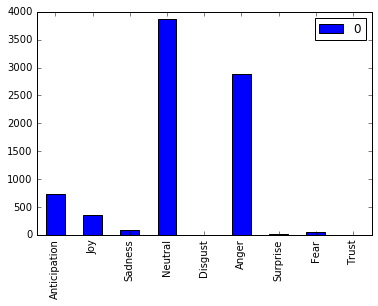

In [46]:
resultUnannotatedTweets = forest.predict(UnAnnotatedTweets)
resultUnannotatedTweets_df = pd.DataFrame()
resultUnannotatedTweets_df['Emotion_Id'] = resultUnannotatedTweets

emo_dict = {
    0: 'Anger',
    1: 'Anticipation',
    2: 'Disgust',
    3: 'Fear',
    4: 'Joy',
    5: 'Sadness',
    6: 'Surprise',
    7: 'Trust',
    8: 'Neutral'
}

resultUnannotatedTweets_df['Emotion'] = [emo_dict[emotion_id] for emotion_id in resultUnannotatedTweets_df['Emotion_Id'] ]
frequency = Counter(resultUnannotatedTweets_df['Emotion'])
df = pd.DataFrame.from_dict(frequency, orient='index')
# Distribution of the tweet dataset after annotating it using the trained model
df.plot(kind='bar')

### 3. Trying SVM with Different Kernels: (linear, radial, polynomial)
Separating hyperplane for unbalanced classes

In [47]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
C = 1.0 # PARAMETERS TO BE FINE TUNED 
gamma = 0.7 # PARAMETERS TO BE FINE TUNED
degree = 9 # PARAMETERS TO BE FINE TUNED
lin_svc = svm.SVC(kernel='linear', C=C, class_weight={1: 9}).fit(X_train, y_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=gamma, C=C,class_weight={1: 9}).fit(X_train, y_train)
poly_svc = svm.SVC(kernel='poly', degree=degree, C=C).fit(X_train, y_train)

In [48]:
result_train_svm_lin = lin_svc.predict(X_train)
result_test_svm_lin = lin_svc.predict(X_test)

In [49]:
result_train_svm_rbf = rbf_svc.predict(X_train)
result_test_svm_rbf = rbf_svc.predict(X_test)

In [50]:
result_train_svm_poly = poly_svc.predict(X_train)
result_test_svm_poly = poly_svc.predict(X_test)

#### 3.1. Labelling Our Geo-Tweets Using Linear SVM:

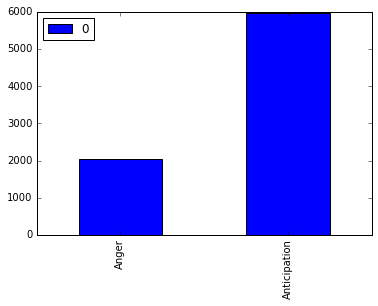

In [51]:
resultUnannotatedTweets = lin_svc.predict(UnAnnotatedTweets)
resultUnannotatedTweets_df = pd.DataFrame()
resultUnannotatedTweets_df['Emotion_Id'] = resultUnannotatedTweets

resultUnannotatedTweets_df['Emotion'] = [emo_dict[emotion_id] for emotion_id in resultUnannotatedTweets_df['Emotion_Id'] ]
frequency = Counter(resultUnannotatedTweets_df['Emotion'])
df = pd.DataFrame.from_dict(frequency, orient='index')
df.plot(kind='bar')

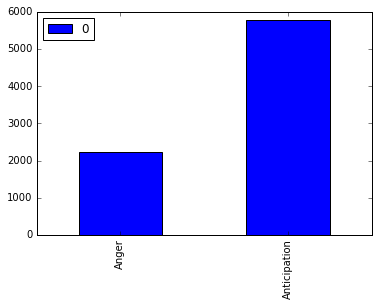

In [52]:
resultUnannotatedTweets = rbf_svc.predict(UnAnnotatedTweets)
resultUnannotatedTweets_df = pd.DataFrame()
resultUnannotatedTweets_df['Emotion_Id'] = resultUnannotatedTweets

resultUnannotatedTweets_df['Emotion'] = [emo_dict[emotion_id] for emotion_id in resultUnannotatedTweets_df['Emotion_Id'] ]
frequency = Counter(resultUnannotatedTweets_df['Emotion'])
df = pd.DataFrame.from_dict(frequency, orient='index')
df.plot(kind='bar')

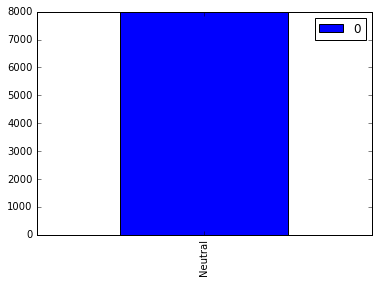

In [53]:
resultUnannotatedTweets = poly_svc.predict(UnAnnotatedTweets)
resultUnannotatedTweets_df = pd.DataFrame()
resultUnannotatedTweets_df['Emotion_Id'] = resultUnannotatedTweets

resultUnannotatedTweets_df['Emotion'] = [emo_dict[emotion_id] for emotion_id in resultUnannotatedTweets_df['Emotion_Id'] ]
frequency = Counter(resultUnannotatedTweets_df['Emotion'])
df = pd.DataFrame.from_dict(frequency, orient='index')
df.plot(kind='bar')

Compared to Random Forest, SVM doesn't give a reasonable fine-grained distribution. This is due to the fact that SVM is hard to tune or the data is not linearly, or radially separated. That's why we use the model trained using Random Forest to label tweet data.

#### 3.2. Model Evaluation for Training: 

In [56]:
print('Accuracy Score: ',metrics.accuracy_score(y_train, result_train_svm_lin))

print('micro Precision Score: ',metrics.precision_score(y_train, result_train_svm_lin, average='micro'))
print('micro Recall Score: ',metrics.recall_score(y_train, result_train_svm_lin, average='micro'))
print('micro f1_score: ',metrics.f1_score(y_train, result_train_svm_lin, average='micro'))

print('macro Precision Score: ',metrics.precision_score(y_train, result_train_svm_lin, average='macro'))
print('macro Recall Score: ',metrics.recall_score(y_train, result_train_svm_lin, average='macro'))
print('macro f1_score: ',metrics.f1_score(y_train, result_train_svm_lin, average='macro'))


('Accuracy Score: ', 0.31723625557206536)
('micro Precision Score: ', 0.31723625557206536)
('micro Recall Score: ', 0.31723625557206536)
('micro f1_score: ', 0.31723625557206536)
('macro Precision Score: ', 0.12467111720894627)
('macro Recall Score: ', 0.18651745270450307)
('macro f1_score: ', 0.11593097433184717)


#### 3.3. Model Evaluation For Testing:

In [58]:
print('Accuracy Score: ',metrics.accuracy_score(y_test, result_test_svm_lin))

print('micro Precision Score: ',metrics.precision_score(y_test, result_test_svm_lin, average='micro'))
print('micro Recall Score: ',metrics.recall_score(y_test, result_test_svm_lin, average='micro'))
print('micro f1_score: ',metrics.f1_score(y_test, result_test_svm_lin, average='micro'))

print('macro Precision Score: ',metrics.precision_score(y_test, result_test_svm_lin, average='macro'))
print('macro Recall Score: ',metrics.recall_score(y_test, result_test_svm_lin, average='macro'))
print('macro f1_score: ',metrics.f1_score(y_test, result_test_svm_lin, average='macro'))

('Accuracy Score: ', 0.11235955056179775)
('micro Precision Score: ', 0.11235955056179775)
('micro Recall Score: ', 0.11235955056179775)
('micro f1_score: ', 0.11235955056179775)
('macro Precision Score: ', 0.012512512512512513)
('macro Recall Score: ', 0.1111111111111111)
('macro f1_score: ', 0.022492127755285654)


Also, the accuracy scores (11% for linear SVM against 34% for Random Forest) advocate for the use of Random Forest as it gives better results.